In [2]:
import pandas as pd
import numpy as np

In [3]:
import math
def correlation_similarity(v1,v2):
    v1 = v1 - np.nanmean(v1)
    v2 = v2 - np.nanmean(v2)
    "compute similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]
        y = v2[i]
        if np.isnan(x) or np.isnan(y) or x == 0 or y ==0: continue
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxx == 0 and sumyy == 0:
        sumxx = sumyy = 1
    return sumxy/math.sqrt(sumxx*sumyy)

def sim_matrix(M, dimension='user'):
    N = M.shape[0] if dimension == 'user' else M.shape[1]
    print(N)
    sim = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i == j:
                sim[i,j] = 0 #Cancel out the effect of self-similarity in the sums later
                continue
            if dimension == 'user':
                v1, v2 = M[i,:], M[j,:]
            else:
                v1, v2 = M[:,i], M[:,j]
            sim[i][j] = correlation_similarity(v1,v2)
    print(sim.shape)
    return sim

# I. Forecasting

## 1. Visualisation

In [4]:
sales_x = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12])
sales_x_target = pd.DataFrame([13,14,15,16])
sales_y = pd.DataFrame([5384,8081,10282,9156,6118,9139,12460,10717,7825,9693,15177,10990])

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

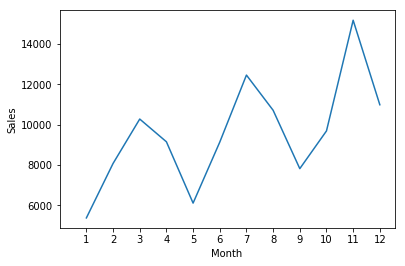

In [6]:
plt.plot(sales_x, sales_y)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(ticks=sales_x)
plt.show()

## 2. Prediction without seasonality

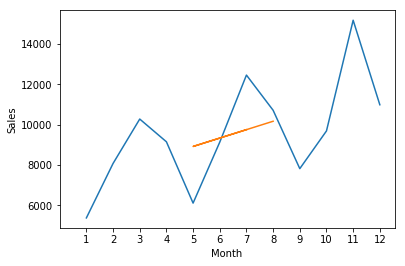

In [7]:
# Applying Linear Regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from random import randint
import pandas as pd

# Predicting for next
sales_x_train, sales_x_test, sales_y_train, sales_y_test = train_test_split(sales_x, 
                                                                            sales_y, 
                                                                            test_size = 0.2, 
                                                                            random_state=randint(0,100))

regr = linear_model.LinearRegression()
regr.fit(sales_x_train.values.reshape(-1,1), sales_y_train.values.reshape(-1,1))
sales_y_pred = regr.predict(sales_x_test)

plt.plot(sales_x, sales_y)
plt.plot(sales_x_test, sales_y_pred)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(ticks=sales_x)
plt.show()

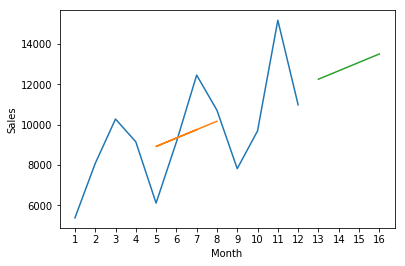

In [8]:
# Predicting for months 13, 14, 15 and 16
sales_x_forecast = pd.Series([13, 14, 15, 16]).values.reshape(-1,1)
sales_y_forecast = regr.predict(sales_x_forecast)

plt.plot(sales_x, sales_y)
plt.plot(sales_x_test, sales_y_pred)
plt.plot(sales_x_forecast, sales_y_forecast)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(ticks=range(1,17))
plt.show()

In [9]:
print("Predictions for months 13, 14, 15 and 16 respectively: " + str(sales_y_forecast))

Predictions for months 13, 14, 15 and 16 respectively: [[12255.59003215]
 [12672.08681672]
 [13088.58360129]
 [13505.08038585]]


## 3. Prediction with seasonality

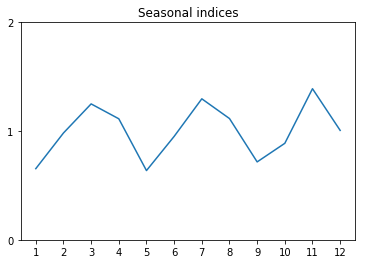

In [10]:
# Compute seasonal indices

seasonal_indices = []
for i in range(0,3):
    seasonal_months = list(range(4*i,(4*i)+4))
    
    # Calculate season average
    seasonal_average = 0
    for j in seasonal_months:
        seasonal_average += sales_y[0][j]
    seasonal_average /= len(seasonal_months)
    
    # Compute average demand?
    
    # Divide each month's sales by it's seasonal average
    for j in seasonal_months:
        seasonal_indices.append(sales_y[0][j] / seasonal_average)

# Seasonality
plt.plot(range(1,13), seasonal_indices)
plt.yticks(ticks=range(0,3))
plt.xticks(ticks=range(1,13))
plt.title("Seasonal indices")
plt.show()

### Deseasonalizing data

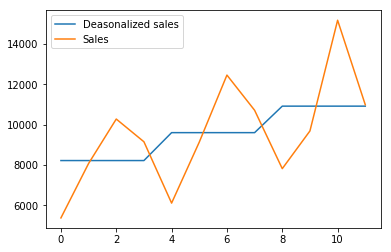

In [11]:
# Deseasonalize data by dividing actual sales data by corresponding seasonal index
deseasonalized_sales_x = sales_x
deseasonalized_sales_y = sales_y[0] / seasonal_indices
plt.plot(deseasonalized_sales_y, label="Deasonalized sales")
plt.plot(sales_y, label="Sales")
plt.legend()
plt.show()

### Regression on de-seasonalized time series

In [12]:
# Apply linear regression on deseasonalized sales data
deseasonalized_x_target = pd.DataFrame([range(13,17)])

regr_dst = linear_model.LinearRegression()
regr_dst.fit(sales_x.values.reshape(-1,1), deseasonalized_sales_y)

deseasonalized_sales_y_pred = regr_dst.predict(deseasonalized_x_target.values.reshape(-1,1))

In [13]:
# Apply linear regression on seasonal indices
seasonal_indices_x_target = deseasonalized_x_target

regr_si = linear_model.LinearRegression()
regr_si.fit(sales_x.values.reshape(-1,1), seasonal_indices)

seasonal_indices_y_pred = regr_si.predict(seasonal_indices_x_target.values.reshape(-1,1))

In [14]:
# Seasonalize data... to some extent. Linear regression doesn't isn't logical here 
#  since it, by nature, won't carry the seasonal fluctuations
projected_sales = deseasonalized_sales_y_pred * seasonal_indices_y_pred

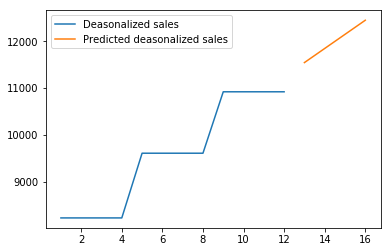

In [15]:
plt.plot(deseasonalized_sales_x, deseasonalized_sales_y, label="Deasonalized sales")
plt.plot(deseasonalized_x_target.values[0], deseasonalized_sales_y_pred, label="Predicted deasonalized sales")
plt.legend()
plt.show()

## 4. Evaluation

In [16]:
actual_data = pd.read_csv("1truth.csv")
actual_data

,Period,Sales
0,13,8050
1,14,11300
2,15,15500
3,16,13000


In [17]:
projected_data = pd.DataFrame({"Period":[13,14,15,16], "Sales":projected_sales})
projected_data

,Period,Sales
0,13,12804.084499
1,14,13337.236679
2,15,13880.504605
3,16,14433.888278


In [18]:
# Forecast errors
error = pd.DataFrame({"Period":[13,14,15,16], "Error%":[0,0,0,0]})

def find_error(approx, actual):
    return ((approx-actual)/actual)*100

for i in range(0,len(actual_data)):
    error["Error%"][i] = find_error(projected_data["Sales"][i], actual_data["Sales"][i])
error

,Period,Error%
0,13,59
1,14,18
2,15,-10
3,16,11


We can see high error in period 13 and also moderate errors in periods 14, 15 and 16.
The errors indicate seasonality was not carried through correctly.

### Conclusion

In conclusion, it can be seen that linear regression is not a suitable choice for approximating changes in seasonal indices, however it may be suitable in approximating changes in deseasonalized data. This can be intuitively reflected upon that linear regressions are, by nature, linear, whereas seasonal indicies fluctuate periodically.

# II. Recommender Systems

## 1. Basics of Recommendation Algorithm

In [140]:
beer_pref_by_item = pd.DataFrame({
    "Desperados": [4,1,0,4],
    "Guinness": [3,2,2,3],
    "chimay triple": [2,3,1,0],
    "Leffe": [3,1,0,0]
})

beer_pref_by_item_true = pd.DataFrame({
    "Desperados": [4,1,1,4],
    "Guinness": [3,2,2,3],
    "chimay triple": [2,3,1,2],
    "Leffe": [3,1,2,4]
})

for df in [beer_pref_by_item, beer_pref_by_item_true]:
    df.rename(index={
        0:"ICT", 
        1:"Medicine", 
        2:"Business", 
        3:"Environment"
    }, inplace=True)

beer_pref_by_user = beer_pref_by_item.transpose()
beer_pref_by_user_true = beer_pref_by_item_true.transpose()

beer_pref_by_user

,ICT,Medicine,Business,Environment
Desperados,4,1,0,4
Guinness,3,2,2,3
chimay triple,2,3,1,0
Leffe,3,1,0,0


The process we will follow for predicting a rating is as follows:

1. Set our target u and i
2. Sum the multiplication of each other user's similarity to u and rating of i
3. Divide this sum by the sum of similarity to all other users, i.e. \sumof sim_by_user[u]

In [96]:
from sklearn.metrics import pairwise_distances

# correlation_similarity(beer_pref_by_user["ICT"], beer_pref_by_user["Business"])

# Create a matrix of similarities
sim_by_user = pd.DataFrame((1 - pairwise_distances(beer_pref_by_user, metric="cosine")))
sim_by_user.columns = ["ICT","Medicine","Business","Environment"]
sim_by_user.rename(index={
    0:"ICT", 
    1:"Medicine", 
    2:"Business", 
    3:"Environment"
}, inplace=True)

# Set the correlation of each user with itself to be 0 to allow maximum calculations further on
for n in ["ICT","Medicine","Business","Environment"]:
    sim_by_user[n][n] = 0

# sim_max contains a 1:1 object with each key being a user and each value being the key's respectively most similar user
sim_maxes = sim_by_user.idxmax()
    
# Manually find the rating for u=Business, i=Desperados
u_target = "Environment"
i_target = "chimay triple"

# Predict rating for u=Business, i=Desperados by collecting sum of similarity * rating for 
#  u=ICT and i=Desperados, u=Medicine and i=Desperados, and u=Environment and i=Desperados.
i_pred = 0
for user in sim_by_user:
    weighted_rating = sim_by_user[u_target][user] * beer_pref_by_user[user][i_target]
    i_pred += weighted_rating

# Divide sum by total similarity with other users    
i_pred /= sum(sim_by_user[u_target])

# Round predicted rating to closest integer
if(i_pred < 1):
    i_pred = 1
elif(i_pred > 5):
    i_pred = 5
elif(i_pred > 1 or i_pred < 5):
    i_pred = round(i_pred)
print("Predicted rating for u=" + u_target + " and i=" + i_target + ": " + str(i_pred))

Predicted rating for u=Environment and i=chimay triple: 2.0


I want to find all occurrences of `missing_value` and predict for them. I can find these occurrences by scanning user by user then item by item and noting each u and i in an object.

In [141]:
def predict_by_user(m, missing_value=0):
    m_pred = m
    users = m.columns
    items = m.index
    missing_values = []
    for u in users:
        for i in items:
            if m[u][i] == missing_value:
                missing_values.append({"User":u,"Item":i})
    
    # Generate similarity matrix
    m_sim = pd.DataFrame((1 - pairwise_distances(m, metric="cosine")))
    m_sim.columns = users
    indices = {}
    for i in range(len(users)):
        indices[i] = users[i]
    m_sim.rename(index=indices, inplace=True)

    # Fix self-correlation to 0
    for u in users:
        m_sim[u][u] = 0
    
    # Predict for all missing value occurrences
    for m_v in missing_values:
        u_target = m_v["User"]
        i_target = m_v["Item"]
        
        # Pred
        ui_pred = 0
        for u in users:
            ui_pred += m_sim[u_target][u] * m[u][i_target]
        ui_pred /= sum(m[u_target])
        
        if(ui_pred < 1):
            ui_pred = 1
        elif(ui_pred > 5):
            ui_pred = 5
        elif(ui_pred > 1 or ui_pred < 5):
            ui_pred = int(round(ui_pred))
        
        m_pred[u_target][i_target] = ui_pred
    return m_pred

print("Predicted:")
print(predict_by_user(beer_pref_by_user))
print("True:")
print(beer_pref_by_user_true)

Predicted:
               ICT  Medicine  Business  Environment
Desperados       4         1         2            4
Guinness         3         2         2            3
chimay triple    2         3         1            1
Leffe            3         1         1            1
True:
               ICT  Medicine  Business  Environment
Desperados       4         1         1            4
Guinness         3         2         2            3
chimay triple    2         3         1            2
Leffe            3         1         2            4


### Calculating predictive accuracy

In [194]:
y_true = beer_pref_by_user_true
y_pred = predict_by_user(beer_pref_by_user)

In [193]:
accuracy_by_user = 100 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100
accuracy = np.mean(accuracy_by_user)

print("Total accuracy: %.2f%%" % accuracy)
print("Accuracy by user: ")
print(accuracy_by_user)

Total accuracy: 82.81%
Accuracy by user: 
ICT            100.00
Medicine       100.00
Business        62.50
Environment     68.75
dtype: float64


### Calculating ranking quality

In [199]:
# Finding ranking quality with Kendall's Tau
import scipy.stats as stats

tau, p_value = stats.kendalltau(y_true, y_pred)
print("Kendall's Tau value: %f" % tau)

Kendall's Tau value: 0.652490


## 2. Movie Recommendations

### Content-based recommendation model

In [550]:
# Importing all data
movies_data = pd.read_csv("movies.csv", encoding="unicode_escape")
ratings_data = pd.read_csv("ratings.csv", encoding="unicode_escape")
users_data = pd.read_csv("users.csv", encoding="unicode_escape")

In [237]:
movies_data.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [418]:
ratings_data.head()

,user_id,movie_id,rating
0,1,1,3
1,1,3,5
2,1,4,4
3,1,5,3
4,1,6,3


In [244]:
users_data.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,2460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


#### Find unique genres

In [332]:
unique_genres = set()

for genre in movies_data["genres"].unique():
    if type(genre) is float:
        continue
    for individual_genre in genre.split("|"):
        unique_genres.add(individual_genre)

In [255]:
listGen = sorted(unique_genres)
print(listGen)

['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Musical', 'Romance', 'Sci-Fi', 'Thriller', 'War']


#### Vectorise relationship between genre and movie

In [396]:
movie_genre_rel = []

for movie in movies_data.values:
    rel = np.array([0] * len(listGen))
    
    if(type(movie[2]) is float):
        movie_genre_rel.append(rel)
        continue
        
    genres = movie[2].split("|")
    for genre in genres:
        rel[listGen.index(genre)] = 1
    movie_genre_rel.append(rel)

In [419]:
Ij = movie_genre_rel
print(Ij[:4])

[array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])]


#### Vectorise relationship between user and genre

In [421]:
##### A relationship between a user and a genre is constituted by a rating being given by the user to a movie of particular genres, regardless of actual value
user_movie_rel = [np.array([0] * len(listGen))] * len(users_data)

for rating in ratings_data.values:
    rel = [0] * len(listGen)
    
    user_id = rating[0]
    movie_id = rating[1]
    rating_value = rating[2]
    
    if(rating_value == 5):    
        user_movie_rel[user_id-1] = user_movie_rel[user_id-1] | movie_genre_rel[movie_id-1]

In [424]:
Uj = user_movie_rel
print(Uj[:4])

[array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int32), array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1], dtype=int32), array([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int32), array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32)]


#### Find cosine similarity between movies and users

In [433]:
user_movie_sim = pd.DataFrame(1 - pairwise_distances(user_movie_rel, metric="cosine"))

In [441]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(user_movie_rel, movie_genre_rel)

array([[0.54772256, 0.36514837, 0.4472136 , ..., 0.4472136 , 0.        ,
        0.4472136 ],
       [0.21821789, 0.        , 0.53452248, ..., 0.53452248, 0.37796447,
        0.53452248],
       [0.19245009, 0.19245009, 0.47140452, ..., 0.47140452, 0.        ,
        0.47140452],
       ...,
       [0.52223297, 0.52223297, 0.42640143, ..., 0.42640143, 0.30151134,
        0.42640143],
       [0.28867513, 0.        , 0.35355339, ..., 0.70710678, 0.        ,
        0.70710678],
       [0.19245009, 0.19245009, 0.23570226, ..., 0.47140452, 0.33333333,
        0.47140452]])

### Collaborative Filtering Recommendation Model by Users

In [443]:
ratings_data.head()

,user_id,movie_id,rating
0,1,1,3
1,1,3,5
2,1,4,4
3,1,5,3
4,1,6,3


In [551]:
# Set up ratings matrix
m_ratings = pd.DataFrame({})

indices = {}
for i in range(len(users_data)):
    indices[i] = i+1
    m_ratings[i+1] = [np.nan] * len(users_data)

m_ratings.rename(index=indices, inplace=True)
m_ratings.rename_axis("movie_id", inplace=True)
m_ratings.rename_axis("user_id", axis="columns", inplace=True)

In [552]:
# Fill in ratings matrix
for r in ratings_data.values:
    
    user_id = r[0]
    movie_id = r[1]
    rating = r[2]
    m_ratings[user_id][movie_id] = rating

m_ratings.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
movie_id,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,3.0,1.0,2.0,5.0,NaN,NaN,4.0,5.0,...,1.0,NaN,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0
2,NaN,4.0,1.0,3.0,4.0,2.0,3.0,1.0,NaN,4.0,...,4.0,5.0,NaN,NaN,4.0,4.0,NaN,3.0,NaN,4.0
3,5.0,5.0,4.0,3.0,4.0,4.0,4.0,3.0,5.0,3.0,...,4.0,5.0,2.0,5.0,3.0,NaN,5.0,5.0,NaN,4.0
4,4.0,NaN,3.0,NaN,4.0,NaN,4.0,NaN,5.0,4.0,...,2.0,4.0,NaN,NaN,3.0,4.0,4.0,5.0,NaN,5.0
5,3.0,5.0,3.0,3.0,NaN,NaN,2.0,4.0,NaN,4.0,...,1.0,5.0,4.0,1.0,NaN,1.0,1.0,3.0,NaN,NaN


In [543]:


# ex.
# from sklearn.model_selection import train_test_split
# import numpy as np

# x = digits.data
# y = digits.target
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=5)